In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import inspect

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Load experimental data (Part 1)
def fun_gauss(x,mu,sigma,amp,offset):
    # toret = amp*norm.pdf(x,loc = mu, scale = sigma)+offset
    toret = amp*np.exp(-np.square(x-mu)/(2*(sigma**2)))+offset
    return toret


In [3]:
# Load experimental data (Part 2)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2
from lmfit import Model

data_exp_bare = pd.read_csv('12052022_3qx.csv')
data_exp_bare2 = pd.read_csv('12062022_3qx.csv')

comphtunes = []
compvtunes = []
compsurvivals = []
compipmturns = []
compsigmas = []
allfits = {}

for fitting_fun,fitting_fun_str in zip([fun_gauss],['Gaussian']):

    for qxi,qyi,survii in zip(data_exp_bare['tune-x'],data_exp_bare['tune-y'],data_exp_bare['mean-survive']):

        # Go through IPM files
        ipmfilepre = str(int(qxi*1000))
        filesipm = sorted(glob.glob('ipm_data/'+ipmfilepre+'_*'))

        for fileipmi in filesipm:

            if fitting_fun_str == 'Gaussian':
                comphtunes.append(qxi)
                compvtunes.append(qyi)
            
            ipmdatai = np.load(fileipmi)
            compipmturni = []
                
            if fitting_fun_str == 'Gaussian':
                compsigmai = []
                emittancei = []

            fits = []

             # Go through every turn of data 
            for nturn, turndata in list(enumerate(ipmdatai)):

                # Create channel numbers 
                channels = np.arange(len(turndata))

                # Smooth channel data
                #turndata = savgol_filter(turndata, window_length=5, polyorder=3)

                # Just get positive count channel plates
                #channels = channels[turndata>0]
                #turndata = turndata[turndata>0]

                # Scale data 
                scaler = MinMaxScaler()
                scaler.fit(turndata.reshape(-1,1))
                yscaled = scaler.transform(turndata.reshape(-1,1)).reshape(1,-1).squeeze()
                #mu0 = np.average(channels, weights = yscaled)
                mu0 = channels[np.argmax(turndata)]
                sigma0 = 5

                # Fit data with corresponding fitting_function
                gmodel = Model(fitting_fun)

                # Get parameters from fitting function
                params = inspect.getfullargspec(fitting_fun)[0][1:]
                numparams = len(params)

                # Add parameters to fit instance
                for parameter in params:

                    if parameter == 'mu':
                        gmodel.set_param_hint('mu', value = mu0, min = 0, max = 80)

                    elif parameter == 'sigma':
                        gmodel.set_param_hint('sigma', value = sigma0, min = 1, max = 50)

                    elif parameter == 'amp':
                        amp0 = np.max(yscaled)
                        gmodel.set_param_hint('amp', value = amp0, min = 0.5*amp0, max = 1.5*amp0)

                    elif parameter == 'ai':
                        gmodel.set_param_hint('ai', value = 0, min = -1, max = 1)

                    elif parameter == 'offset':
                        offset0 = scaler.transform(np.mean(turndata[-40:]).reshape(-1, 1))
                        offset0 = float(offset0.squeeze())
                        gmodel.set_param_hint('offset', value = offset0, min = -0.1, max = 0.5)
                    
                    elif parameter == 'q':
                        qmin = -0.5
                        qmax = 2.9
                        gmodel.set_param_hint('q', value = 1.1, min = qmin, max = qmax)

                # Fit data and add to global array
                sigmai = 2*np.std(turndata[-20:])
                sigmaiforfit = float(scaler.transform(sigmai.reshape(-1, 1)).squeeze())
                fit = gmodel.fit(yscaled, x = channels, #nan_policy = 'omit',
                                 weights = (1.0/(scaler.scale_*sigmai))*np.ones_like(turndata))
                #fits.append(fit)
                datafit = scaler.inverse_transform((fit.best_fit).reshape(-1,1)).reshape(1,-1).squeeze()

                chi2_95 = chi2.ppf(q = 0.95, df = fit.nfree)

                if (chi2_95>fit.chisqr) and (fit.values['mu']<40):
                    if fitting_fun_str == 'Gaussian':
                        fits.append(fit)
                        compipmturni.append(nturn)
                        compsigmai.append(fit.best_values['sigma'])
                    
                    elif fitting_fun_str == 'qGaussian':
                        if (fit.values['q']<0.99*qmax) and (fit.values['q']>0.99*qmin):
                            compipmturni.append(nturn)
                            fits.append(fit)

            if fitting_fun_str == 'Gaussian':
                compipmturns.append(compipmturni)
                compsigmas.append(compsigmai)
                compsurvivals.append(survii)

            # break
        # break

In [4]:
# Load experimental data (Part 3)

collapsed_htune = np.unique(comphtunes)
collapsed_sigmas = []
collapsed_survive = []
collapsed_survive_std = []
collapsed_turns = []

for tune in collapsed_htune:
    
    sigmapertune = np.array([])
    survivepertune = np.array([]) 
    turnpertune = np.array([])
    
    for tunei,sigmalisti,survi,turnj in zip(comphtunes,compsigmas,compsurvivals,compipmturns):
        if tunei==tune:
            turnpertune = np.concatenate((turnpertune,turnj))
            sigmapertune = np.concatenate((sigmapertune,sigmalisti))
            survivepertune = np.append(survivepertune,survi)
            
    # Introduce 0.5 mm for MCP resolution
    collapsed_sigmas.append(0.5*sigmapertune)
    collapsed_survive.append(np.mean(survivepertune))
    collapsed_survive_std.append(np.std(survivepertune))
    collapsed_turns.append(turnpertune)

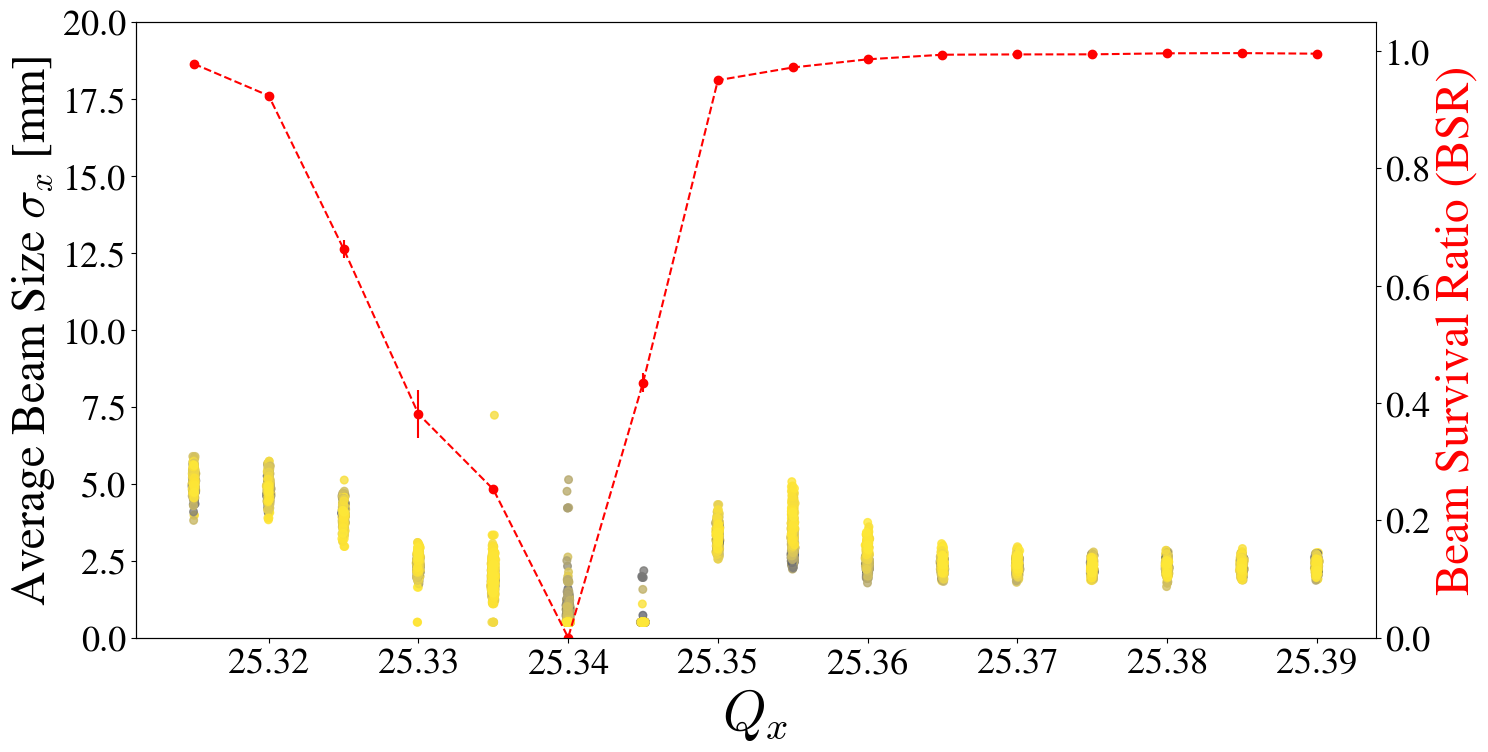

In [5]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = data_exp_bare['tune-x'],y = data_exp_bare['mean-survive'], yerr = data_exp_bare['std-survive'],
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)

axtt = ax

for htunei,ei,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns): 
    s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
                   s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

# cbar = fig.colorbar(s, ax=ax, pad = 0.1)
# cbar.set_label('Decimated Turn Number',fontsize = 32)
# cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

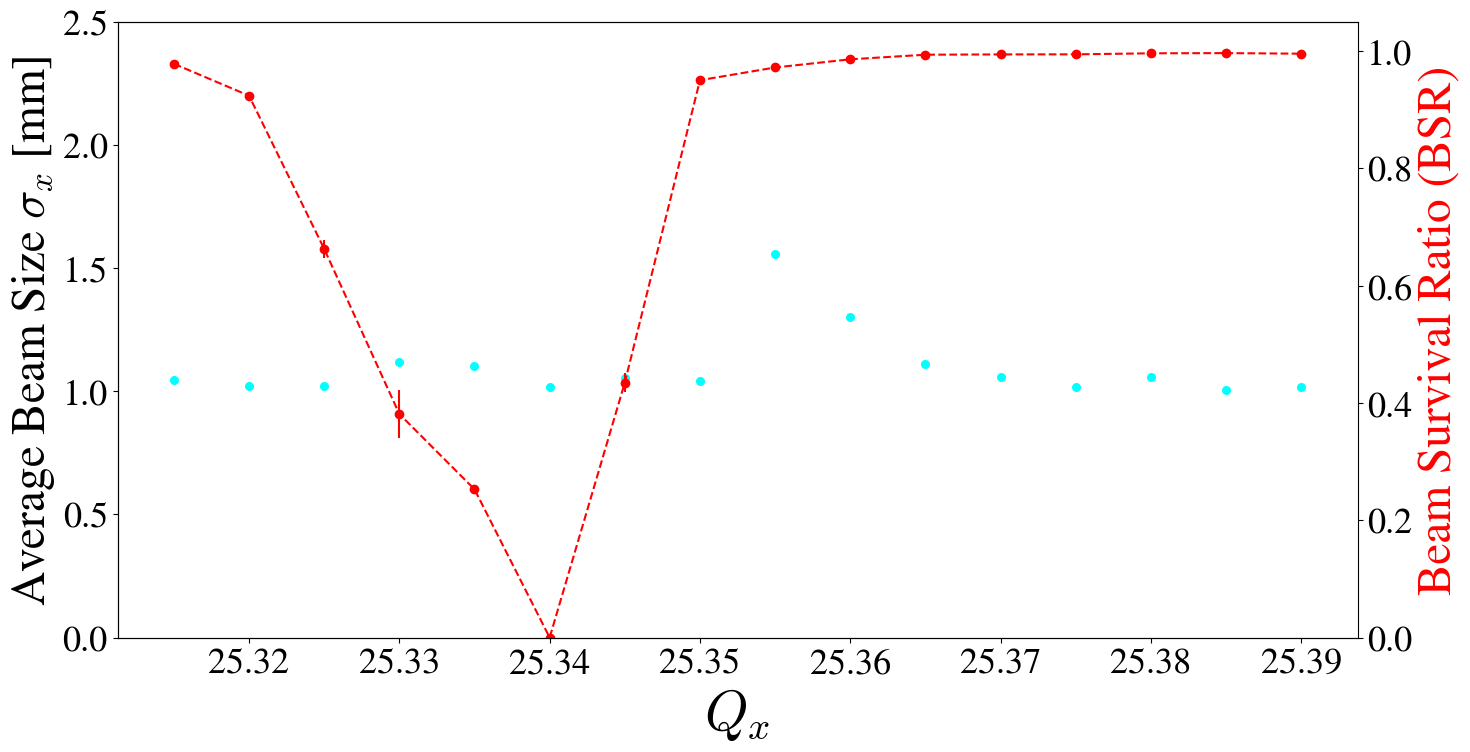

In [6]:
fig,ax = plt.subplots(1,1,figsize=(16,8))

normalize = plt.Normalize(0, 100)
cmap = plt.colormaps["cividis"]

axt = ax.twinx()
axt.errorbar(x = data_exp_bare['tune-x'],y = data_exp_bare['mean-survive'], yerr = data_exp_bare['std-survive'],
             fmt = 'o--',c = 'red',label = 'BSR')

axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')
axt.set_ylim(0.0,1.05)
axt.tick_params(axis='both', labelsize=26)

#plt.legend()
ax.set_ylim(-0.,2.5)
ax.tick_params(axis='both', labelsize=26)
ax.set_xlabel(r'$Q_x$',fontsize=40)
ax.set_ylabel('Average q-factor',fontsize= 34)

axtt = ax

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns):

    fit = np.polyfit(turnsi,si,7)
    poly = np.poly1d(fit)
    
    xspace = np.arange(0,1024)
    sspace = poly(xspace)

    # axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
    axtt.scatter([htunei],[np.max(sspace)/np.mean(sspace[:100])], s = 30, c = 'cyan')
    
    # s = axtt.scatter((np.ones_like(htunei)*htunei+0.005*np.random.normal(loc = 0.0, scale = 0.01,size = len(ei))),ei, 
    #                s = 30,c = turnsi, cmap = cmap, norm = matplotlib.colors.LogNorm(), label = 'Beam Size',alpha = 0.8)

# axtt.set_ylim(0,20)
axtt.spines.right.set_position(("axes", 1.15))
axtt.set_ylabel(r'Average Beam Size $\sigma_x$ [mm]',fontsize= 34)
axtt.tick_params(axis='both', labelsize=26)

# cbar = fig.colorbar(s, ax=ax, pad = 0.1)
# cbar.set_label('Decimated Turn Number',fontsize = 32)
# cbar.ax.tick_params(axis='y', labelsize = 22)

h,l = ax.get_legend_handles_labels()
hh,ll = axt.get_legend_handles_labels()
hhh,lll = axtt.get_legend_handles_labels()
# ax.legend([h[1],hh[-1],hhh[-1]],[l[1],ll[-1],lll[-1]],loc = (0.66,0.66),fontsize = 22)

plt.show()
plt.close()

In [7]:
# Load simulation data

survfiles = sorted(glob.glob('72800turns/surv*.npy'))
qxsfiles = sorted(glob.glob('72800turns/qxtuned*.npy'))
x_stdfiles = sorted(glob.glob('72800turns/x_std*.npy'))
countfiles = sorted(glob.glob('72800turns/count*.npy'))

survs = np.array([])
qxs = np.array([])
sigmax_growths = np.array([])
counts = []

for survfilei,qxfilei,x_stdfilei,countfilei in zip(survfiles,qxsfiles,x_stdfiles,countfiles):
    survi = np.load(survfilei)
    survs = np.append(survi,survs)

    qxi = np.load(qxfilei)
    qxs = np.append(qxi,qxs)

    x_stdi = np.load(x_stdfilei)
    sigmax_growthi = np.max(x_stdi)/x_stdi[0]
    sigmax_growths = np.append(sigmax_growthi,sigmax_growths)

    counti = np.load(countfilei)
    counts.append(counti)

    # break
counts = np.array(counts)

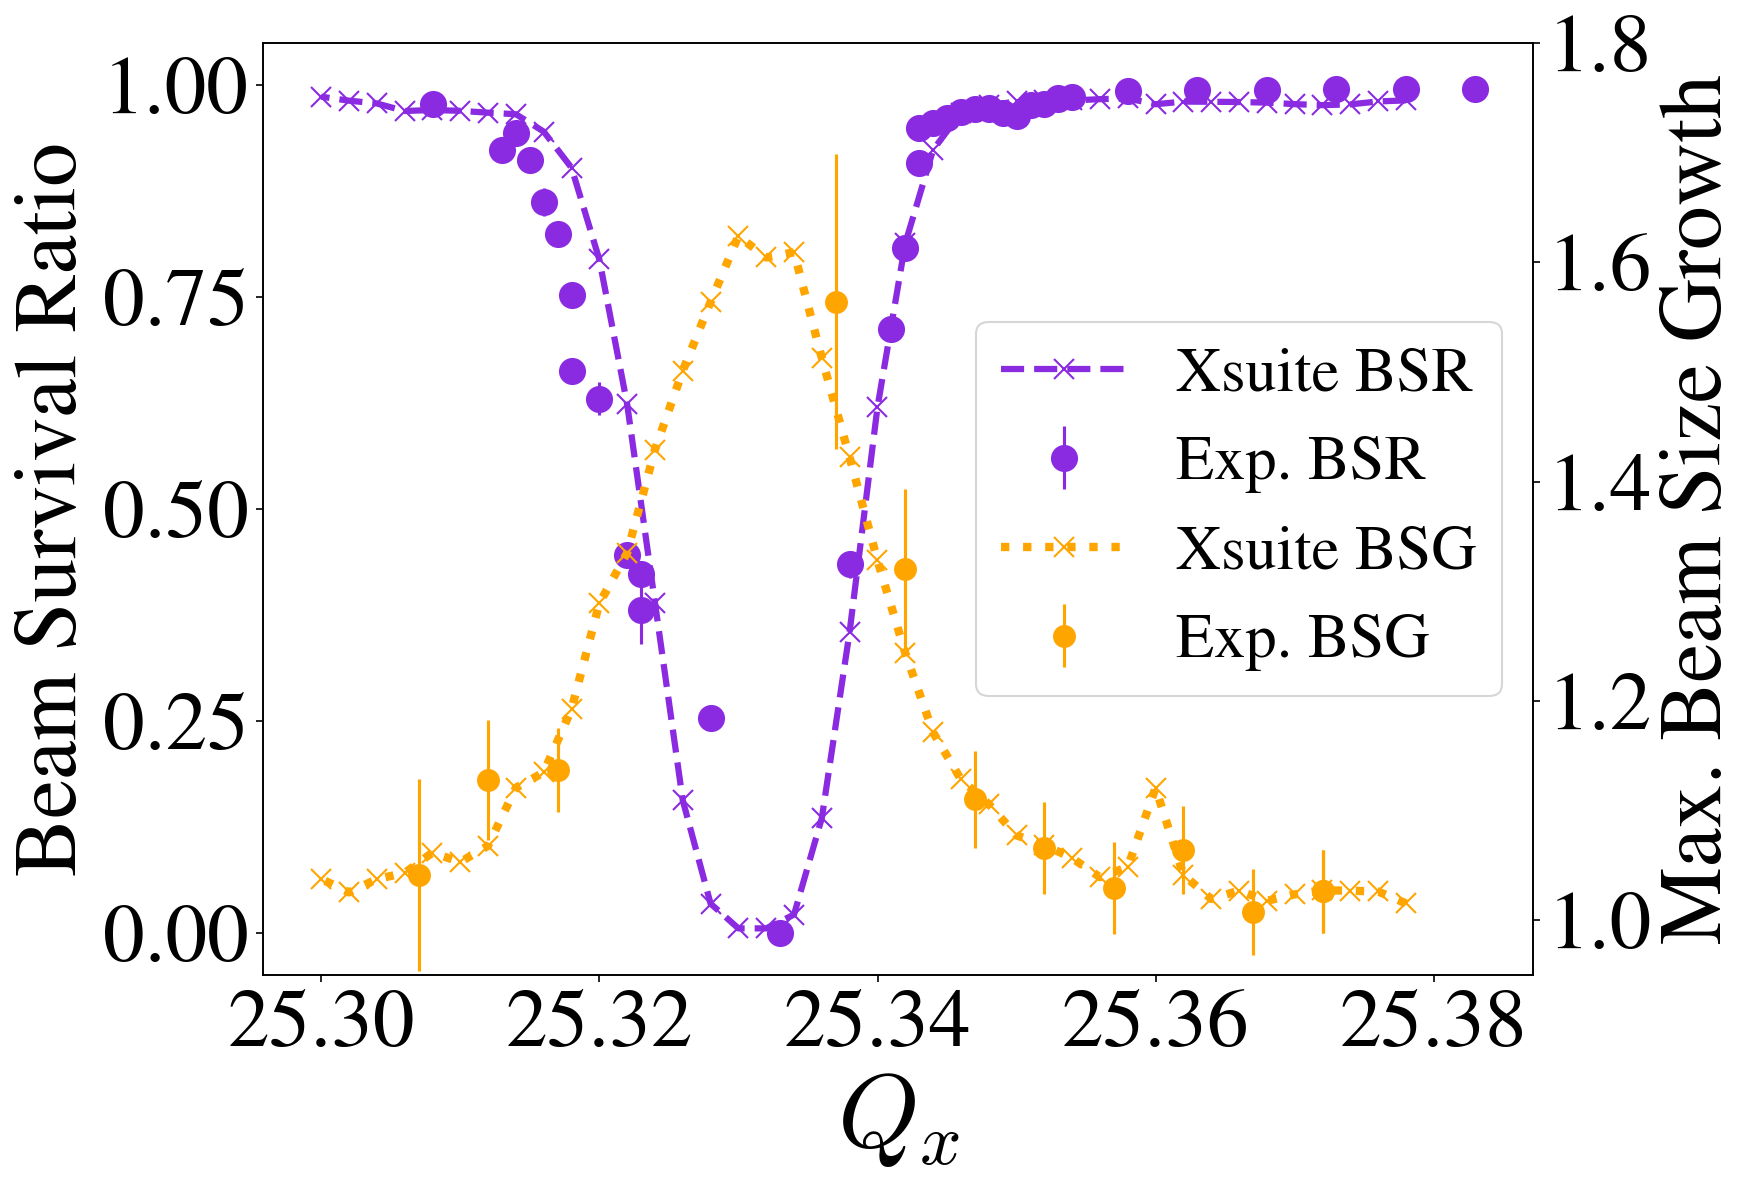

In [16]:
fig,ax = plt.subplots(1,1,figsize = (11.8,8))

fig.set_dpi(150)

ax.plot(qxs,survs, marker = 'x', linewidth = 3,markersize = 10,linestyle = '--', color = 'blueviolet',label = 'Xsuite BSR')

ax.errorbar(x = data_exp_bare['tune-x']-0.007,y = data_exp_bare['mean-survive'], yerr = data_exp_bare['std-survive'],
             color = 'blueviolet', fmt = 'o', markersize =12)


data_plot2 = data_exp_bare2[(data_exp_bare2['std-survive']<0.02) & (np.invert(data_exp_bare2['tune-x'].between(25.330,25.346)))]

ax.errorbar(x = data_plot2['tune-x']-0.006,y = data_plot2['mean-survive'], yerr = data_plot2['std-survive'], label = 'Exp. BSR',
             color = 'blueviolet', fmt = 'o', markersize =12)


axt.set_ylabel('Beam Survival Ratio (BSR)', fontsize = 34, color = 'red')

ax.set_xlabel(r'$Q_x$',fontsize =50)
ax.set_ylabel(r'Beam Survival Ratio',fontsize =42)

ax.tick_params(axis='both', labelsize=40)

axt = ax.twinx()

axt.plot(qxs,sigmax_growths, c = 'orange', marker = 'x',linestyle = 'dotted',linewidth = 4,markersize = 10, label = 'Xsuite BSG')

for htunei,si,turnsi in zip(collapsed_htune,collapsed_sigmas,collapsed_turns):

    if (htunei >25.35) or ((htunei < 25.34) and (htunei > 25.32)):
        fit = np.polyfit(turnsi,si,8)
        poly = np.poly1d(fit)
        
        xspace = np.arange(0,1024)
        sspace = poly(xspace)
    
        serror = 3*2*np.std(si)/np.sqrt(len(si))
    
        # axtt.scatter([htunei],[np.mean(si[:100])], s = 30, c = 'k')
        axt.errorbar([htunei-0.018],[np.max(sspace)/np.mean(sspace[:50])],yerr = serror, fmt = 'o',
                     markersize = 10, c = 'orange')

axt.errorbar([htunei-0.018],[np.max(sspace)/np.mean(sspace[:50])], yerr = serror, fmt = 'o', markersize = 10, c = 'orange',label = 'Exp. BSG')

lt,ht = axt.get_legend_handles_labels()
legends,handles = ax.get_legend_handles_labels()

legends.append(lt[0])
handles.append(ht[0])

legends.append(lt[1])
handles.append(ht[1])

ax.legend(legends,handles,loc = 'center right', fontsize = 30)

ax.set_ylim(-0.05,1.05)
axt.set_ylim(0.95,1.8)

# axt.set_ylabel(r'$\sigma_{x,MAX} / \sigma_{x,0}$',fontsize =42)
axt.set_ylabel(r'Max. Beam Size Growth',fontsize =42)

axt.tick_params(axis='both', labelsize=40)

plt.tight_layout()
fig.savefig('static2turns_more.pdf')

plt.show()
plt.close()

In [9]:
# data_exp_bare = pd.read_csv('12052022_3qx.csv')
# data_exp_bare2 = pd.read_csv('12062022_3qx.csv')

In [10]:
data_exp_bare2[data_exp_bare2['std-survive']<0.02]

,tune-x,tune-y,Nint,max-int,min-int,mean-survive,std-survive,Nipm,mean-gauss-mu,std-gauss-mu,mean-gauss-sigma,std-gauss-sigma,mean-gauss-amp,std-gauss-amp,mean-beamsize-growth,std-beamsize-growth
0,25.320,24.43,3,0.504733,0.473333,0.944345,0.008271,3,9.533235,4.888799,13.486667,2.359170,16.585750,2.326171,1.030422,0.034809
1,25.321,24.43,3,0.512933,0.464300,0.912020,0.004196,3,9.551472,4.511374,12.912183,2.192354,16.010835,2.251992,1.016246,0.025027
2,25.322,24.43,3,0.517733,0.441433,0.862269,0.016417,3,9.744720,4.193835,12.198554,2.005069,15.343065,2.140913,1.001726,0.007169
3,25.323,24.43,3,0.506433,0.412833,0.824041,0.012360,3,10.696296,5.043635,11.767103,2.101928,15.215654,2.116216,1.013123,0.002016
4,25.324,24.43,3,0.516800,0.383567,0.752303,0.005428,3,10.694721,4.685188,11.180808,1.891286,14.509603,2.035041,1.021692,0.037356
6,25.326,24.43,3,0.499733,0.308033,0.630272,0.019180,3,11.884686,4.950614,9.796562,1.826029,13.177525,1.921570,1.129441,0.037940
8,25.328,24.43,3,0.498433,0.215367,0.445939,0.002644,3,13.420056,4.341921,7.148278,1.397469,10.716806,1.376849,1.171147,0.039237
9,25.329,24.43,3,0.477900,0.196533,0.423822,0.015046,3,13.420606,3.684460,6.094223,1.099262,9.702648,1.172027,1.140389,0.015646
11,25.331,24.43,3,0.463000,0.404000,0.890215,0.001727,3,13.331765,3.010848,5.162495,0.778378,8.846943,0.919829,0.979287,0.011581
15,25.335,24.43,3,0.370667,0.098767,0.283722,0.008903,3,14.138352,2.922350,4.701417,0.812928,7.863451,0.895822,1.097381,0.028263


In [11]:
np.invert(data_exp_bare2['tune-x'].between(25.330,25.340))

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
Name: tune-x, dtype: bool